In [12]:
# !pip install torchview torchsummary torchvision kornia torchmetrics matplotlib tqdm path graphviz opencv-python scikit-learn optuna

In [2]:
# system
import sys
sys.path.append('..')

# data
import numpy as np

# deep learning
import torch
import torch.nn as nn
from torch.distributions.transforms import LowerCholeskyTransform
from torch.distributions.multivariate_normal import MultivariateNormal
from torch.utils.data import DataLoader, Dataset

# torchvision
import torchvision

# plotting
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm

# utils and model
from utils.utils import (
    seedEverything,
    compute_mean_std,
    data_transform,
    normalize,
    plot_images,
)

from utils.model import ConvNN

# FIXMATCH
from fixmatch import mask, fixmatch_train

# os
import os
import path

# sklearn - confusion matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


%load_ext autoreload
%autoreload 2

In [3]:
# Set device
if ((int(torch.__version__.split(".")[0]) >= 2) or (int(torch.__version__.split(".")[1]) >= 13)) and torch.has_mps:
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

print(device)

cuda


In [4]:
IMG_SHAPE = (3, 32, 32)
# See Table 4
TAU = 0.95
LAMBDA_U = 1
MU = 7
BATCH_SIZE = 64
LR = 0.03
BETA = 0.9
WEIGHT_DECAY = 0.0005

In [5]:
# Download both datasets
trainset = torchvision.datasets.CIFAR10(
    root='../data', train=True, download=True, transform=data_transform())
testset = torchvision.datasets.CIFAR10(
    root='../data', train=False, download=True, transform=data_transform())

# convert to data loaders
trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
testloader = torch.utils.data.DataLoader(
    testset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

Files already downloaded and verified
Files already downloaded and verified


In [6]:
# compute mean and std
if not os.path.exists('../data/mean.pt'):
    mean, std = compute_mean_std(trainloader)
    torch.save(mean, '../data/mean.pt')
    torch.save(std, '../data/std.pt')
else:
    mean, std = torch.load('../data/mean.pt'), torch.load('../data/std.pt')

# to numpy
mean, std = mean.numpy(), std.numpy()

print(f"mean: {mean}, std: {std}")

mean: [0.49135667 0.48212072 0.4465159 ], std: [0.24632095 0.24274482 0.26062676]


In [7]:
# define classes
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


In [8]:
torch_models = './results/models/' 
if not os.path.exists(torch_models):
    os.makedirs(torch_models)

## III. Semi-Supervised Learning: Fixmatch

### III.1 Fixmatch on 10% train data

In [33]:
# fix the seed
seedEverything()

# 10% labeled data and 100% unlabeled (see note 2 in paper)
SUBSET_PROP = 0.10
trainset_sup, _ = torch.utils.data.random_split(trainset, [SUBSET_PROP, 1-SUBSET_PROP])

trainset_unsup, _ = torch.utils.data.random_split(trainset, [1, 0])

labeled_dataloader = DataLoader(
    trainset_sup,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=0
)

unlabeled_dataloader = DataLoader(
    trainset_unsup,
    batch_size=MU*BATCH_SIZE,
    shuffle=True,
    num_workers=0
)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataset.py:348: UserWarning: Length of split at index 1 is 0. This might result in an empty dataset.
  warnings.warn(f"Length of split at index {i} is 0. "


In [34]:
EPOCHS = 300

model = ConvNN().to(device)

# criterion and optimizer
labeled_criterion = nn.CrossEntropyLoss(reduction='none')
unlabeled_criterion = nn.CrossEntropyLoss(reduction='none')

optimizer = torch.optim.SGD(model.parameters(), lr=LR, momentum=BETA, weight_decay=WEIGHT_DECAY, nesterov=True)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)

In [35]:
fixmatch_train(
    model=model,
    labeled_dataloader=labeled_dataloader,
    unlabeled_dataloader=unlabeled_dataloader,
    testloader=testloader,
    labeled_criterion=labeled_criterion,
    unlabeled_criterion=unlabeled_criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    epochs=EPOCHS,
    mean=mean,
    std=std,
    lambda_u=LAMBDA_U,
    tau=TAU,
    mu=MU,
    batch_size=BATCH_SIZE,
    name='10'
)

Start training


Epoch     0:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 23.06%


Epoch     1:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 27.0%


Epoch     2:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 38.36%


Epoch     3:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 41.6%


Epoch     4:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 46.48%


Epoch     5:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 48.2%


Epoch     6:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 45.93%


Epoch     7:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 48.85%


Epoch     8:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 51.6%


Epoch     9:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 56.92%


Epoch    10:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 53.9%


Epoch    11:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 53.18%


Epoch    12:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 59.76%


Epoch    13:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 59.25%


Epoch    14:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 59.0%


Epoch    15:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 57.26%


Epoch    16:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 57.4%


Epoch    17:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 61.43%


Epoch    18:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 63.89%


Epoch    19:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 64.91%


Epoch    20:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 64.41%


Epoch    21:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 59.64%


Epoch    22:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 63.56%


Epoch    23:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 65.87%


Epoch    24:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 65.35%


Epoch    25:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 63.72%


Epoch    26:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 66.35%


Epoch    27:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 65.94%


Epoch    28:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 66.92%


Epoch    29:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 66.58%


Epoch    30:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 66.68%


Epoch    31:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 67.78%


Epoch    32:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 67.27%


Epoch    33:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 67.39%


Epoch    34:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 66.4%


Epoch    35:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 68.35%


Epoch    36:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 69.2%


Epoch    37:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 67.21%


Epoch    38:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 68.78%


Epoch    39:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 68.2%


Epoch    40:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 69.53%


Epoch    41:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 69.27%


Epoch    42:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 69.07%


Epoch    43:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 68.62%


Epoch    44:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 68.92%


Epoch    45:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 68.2%


Epoch    46:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 69.67%


Epoch    47:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 68.57%


Epoch    48:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 69.59%


Epoch    49:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 70.4%


Epoch    50:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 71.01%


Epoch    51:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 69.07%


Epoch    52:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 71.79%


Epoch    53:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 69.34%


Epoch    54:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 72.69%


Epoch    55:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 70.75%


Epoch    56:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 72.85%


Epoch    57:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 70.11%


Epoch    58:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 71.61%


Epoch    59:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 71.2%


Epoch    60:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 71.06%


Epoch    61:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 71.39%


Epoch    62:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 70.85%


Epoch    63:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 71.95%


Epoch    64:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 71.69%


Epoch    65:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 72.53%


Epoch    66:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 72.29%


Epoch    67:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 71.47%


Epoch    68:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 72.4%


Epoch    69:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 73.12%


Epoch    70:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 72.5%


Epoch    71:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 72.16%


Epoch    72:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 72.95%


Epoch    73:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 72.43%


Epoch    74:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 72.01%


Epoch    75:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 73.61%


Epoch    76:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 72.99%


Epoch    77:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 73.19%


Epoch    78:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 74.1%


Epoch    79:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 74.25%


Epoch    80:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 72.99%


Epoch    81:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 74.02%


Epoch    82:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 73.71%


Epoch    83:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 72.56%


Epoch    84:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 72.79%


Epoch    85:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 73.71%


Epoch    86:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 74.36%


Epoch    87:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 74.44%


Epoch    88:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 73.55%


Epoch    89:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 73.38%


Epoch    90:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 73.12%


Epoch    91:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 74.23%


Epoch    92:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 72.51%


Epoch    93:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 75.06%


Epoch    94:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 74.32%


Epoch    95:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 73.98%


Epoch    96:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 74.65%


Epoch    97:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 74.84%


Epoch    98:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 75.21%


Epoch    99:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 73.93%


Epoch   100:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 75.23%


Epoch   101:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 75.63%


Epoch   102:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 74.19%


Epoch   103:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 75.16%


Epoch   104:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 75.36%


Epoch   105:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 75.28%


Epoch   106:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 75.51%


Epoch   107:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 75.0%


Epoch   108:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 75.62%


Epoch   109:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 75.54%


Epoch   110:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 75.65%


Epoch   111:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 74.4%


Epoch   112:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 76.15%


Epoch   113:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 75.96%


Epoch   114:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 76.33%


Epoch   115:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 75.5%


Epoch   116:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 76.24%


Epoch   117:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 76.23%


Epoch   118:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 75.57%


Epoch   119:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 76.5%


Epoch   120:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 77.09%


Epoch   121:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 76.4%


Epoch   122:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 76.11%


Epoch   123:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 76.19%


Epoch   124:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 76.84%


Epoch   125:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 76.69%


Epoch   126:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 77.3%


Epoch   127:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 77.41%


Epoch   128:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 76.64%


Epoch   129:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 76.99%


Epoch   130:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 76.88%


Epoch   131:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 77.05%


Epoch   132:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 77.64%


Epoch   133:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 77.44%


Epoch   134:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 76.73%


Epoch   135:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 77.6%


Epoch   136:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 77.26%


Epoch   137:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 77.05%


Epoch   138:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 77.15%


Epoch   139:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 77.69%


Epoch   140:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 77.98%


Epoch   141:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 77.17%


Epoch   142:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 77.46%


Epoch   143:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 78.5%


Epoch   144:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 77.44%


Epoch   145:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 78.53%


Epoch   146:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 77.98%


Epoch   147:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 77.68%


Epoch   148:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 78.09%


Epoch   149:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 77.36%


Epoch   150:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 77.6%


Epoch   151:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 78.85%


Epoch   152:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 78.37%


Epoch   153:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 78.41%


Epoch   154:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 77.9%


Epoch   155:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 78.77%


Epoch   156:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 78.31%


Epoch   157:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 78.46%


Epoch   158:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 79.1%


Epoch   159:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 79.24%


Epoch   160:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 79.07%


Epoch   161:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 79.08%


Epoch   162:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 78.79%


Epoch   163:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 78.91%


Epoch   164:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 78.62%


Epoch   165:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 78.51%


Epoch   166:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 78.76%


Epoch   167:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 79.23%


Epoch   168:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 78.84%


Epoch   169:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 78.97%


Epoch   170:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 78.16%


Epoch   171:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 79.22%


Epoch   172:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 79.25%


Epoch   173:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 78.85%


Epoch   174:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 79.21%


Epoch   175:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 79.41%


Epoch   176:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 79.55%


Epoch   177:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 78.72%


Epoch   178:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 79.33%


Epoch   179:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 79.24%


Epoch   180:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 79.03%


Epoch   181:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 79.49%


Epoch   182:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 79.98%


Epoch   183:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 79.33%


Epoch   184:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 79.71%


Epoch   185:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 79.49%


Epoch   186:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 79.39%


Epoch   187:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 79.48%


Epoch   188:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 79.68%


Epoch   189:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 80.02%


Epoch   190:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 79.79%


Epoch   191:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 80.0%


Epoch   192:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 79.73%


Epoch   193:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 79.62%


Epoch   194:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 79.63%


Epoch   195:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 79.31%


Epoch   196:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 79.86%


Epoch   197:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 79.91%


Epoch   198:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 79.73%


Epoch   199:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 80.18%


Epoch   200:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 79.93%


Epoch   201:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 80.25%


Epoch   202:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 79.97%


Epoch   203:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 79.69%


Epoch   204:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 80.09%


Epoch   205:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 80.15%


Epoch   206:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 80.18%


Epoch   207:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 79.94%


Epoch   208:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 80.21%


Epoch   209:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 80.06%


Epoch   210:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 79.84%


Epoch   211:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 80.38%


Epoch   212:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 80.41%


Epoch   213:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 80.06%


Epoch   214:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 80.21%


Epoch   215:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 80.18%


Epoch   216:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 80.44%


Epoch   217:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 80.42%


Epoch   218:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 80.74%


Epoch   219:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 80.25%


Epoch   220:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 80.74%


Epoch   221:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 80.52%


Epoch   222:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 80.27%


Epoch   223:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 80.83%


Epoch   224:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 79.9%


Epoch   225:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 80.25%


Epoch   226:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 80.39%


Epoch   227:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 80.78%


Epoch   228:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 80.62%


Epoch   229:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 80.81%


Epoch   230:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 80.75%


Epoch   231:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 80.55%


Epoch   232:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 80.86%


Epoch   233:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 80.63%


Epoch   234:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 80.44%


Epoch   235:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 80.81%


Epoch   236:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 80.88%


Epoch   237:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 80.79%


Epoch   238:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 80.56%


Epoch   239:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 80.98%


Epoch   240:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 80.85%


Epoch   241:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 80.93%


Epoch   242:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 80.72%


Epoch   243:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 80.79%


Epoch   244:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 80.79%


Epoch   245:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 80.76%


Epoch   246:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 80.82%


Epoch   247:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 80.64%


Epoch   248:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 80.83%


Epoch   249:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 80.7%


Epoch   250:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 80.69%


Epoch   251:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 80.66%


Epoch   252:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 80.46%


Epoch   253:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 80.94%


Epoch   254:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 80.93%


Epoch   255:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 80.87%


Epoch   256:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 80.66%


Epoch   257:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 80.79%


Epoch   258:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 81.15%


Epoch   259:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 80.96%


Epoch   260:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 80.98%


Epoch   261:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 80.99%


Epoch   262:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 81.12%


Epoch   263:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 80.82%


Epoch   264:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 80.91%


Epoch   265:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 81.08%


Epoch   266:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 81.13%


Epoch   267:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 81.07%


Epoch   268:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 80.82%


Epoch   269:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 80.95%


Epoch   270:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 80.97%


Epoch   271:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 80.93%


Epoch   272:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 81.18%


Epoch   273:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 81.2%


Epoch   274:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 80.94%


Epoch   275:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 80.93%


Epoch   276:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 81.17%


Epoch   277:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 80.99%


Epoch   278:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 81.05%


Epoch   279:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 81.04%


Epoch   280:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 81.05%


Epoch   281:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 81.07%


Epoch   282:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 81.1%


Epoch   283:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 81.12%


Epoch   284:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 81.01%


Epoch   285:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 81.12%


Epoch   286:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 80.94%


Epoch   287:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 81.06%


Epoch   288:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 81.1%


Epoch   289:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 81.11%


Epoch   290:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 81.02%


Epoch   291:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 81.01%


Epoch   292:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 81.06%


Epoch   293:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 81.08%


Epoch   294:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 81.0%


Epoch   295:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 80.97%


Epoch   296:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 81.0%


Epoch   297:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 80.99%


Epoch   298:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 80.99%


Epoch   299:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 80.99%
Finished Training


In [36]:
# open results
model_10 = ConvNN().to(device)
model_10.load_state_dict(torch.load('./results/models/model_10.pth'))
train_losses_10 = torch.load('./results/metrics/train_losses_10.pth')
train_accuracies_10 = torch.load('./results/metrics/train_accuracies_10.pth')
test_losses_10 = torch.load('./results/metrics/test_losses_10.pth')
test_accuracies_10 = torch.load('./results/metrics/test_accuracies_10.pth')

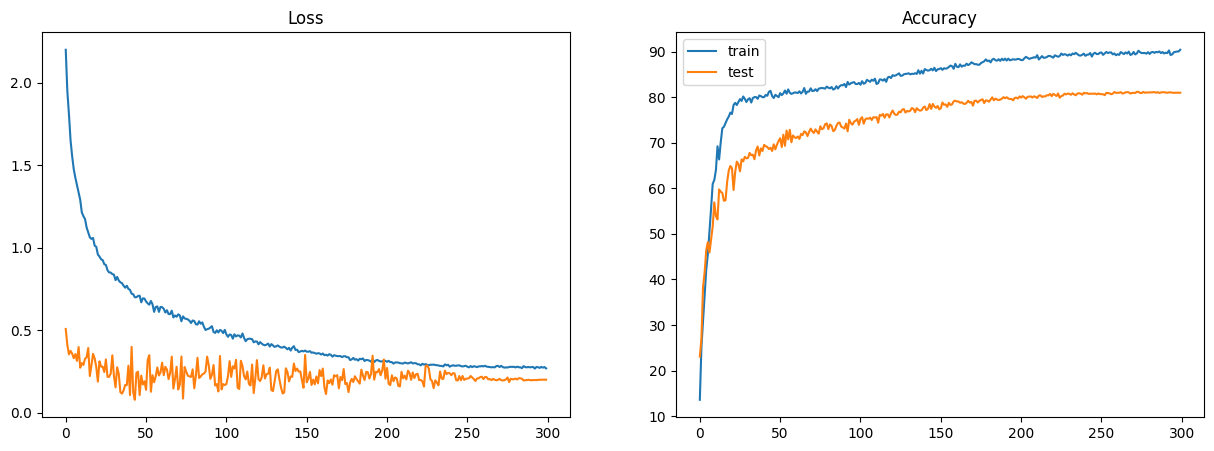

In [37]:
# plot losses and accuracies
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.plot(train_losses_10, label="train")
ax1.plot(test_losses_10, label="test")
ax1.set_title("Loss")

ax2.plot(train_accuracies_10, label="train")
ax2.plot(test_accuracies_10, label="test")
ax2.set_title("Accuracy")

plt.legend()
plt.show()

# save plot
fig.savefig(f"./results/figures/losses_accuracies_10.png")

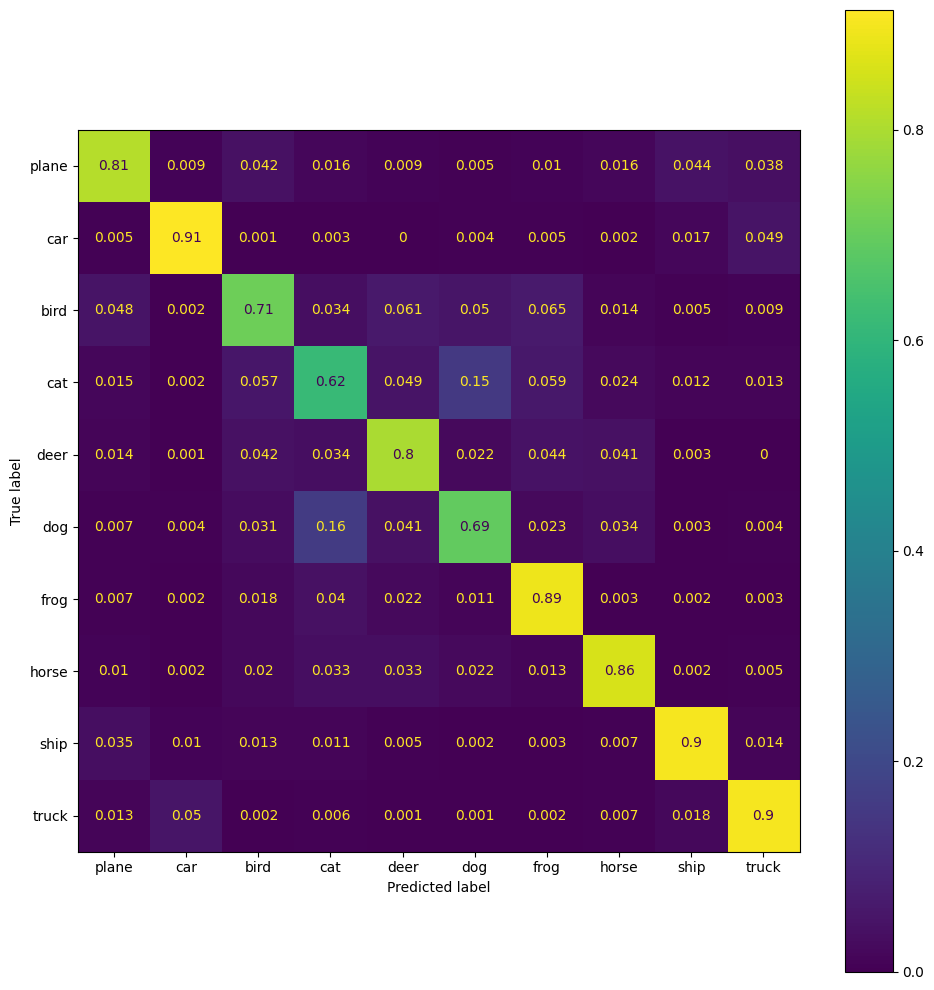

In [38]:
# plot confusion matrix
model.eval()  # Set the model to evaluation mode
test_correct = 0
test_total = 0
y_true = []
y_pred = []

with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        # normalize
        images = normalize(mean, std)(images)
        
        outputs = model_10(images)
        _, predicted = outputs.max(1)
        test_total += labels.size(0)
        test_correct += predicted.eq(labels).sum().item()

        y_true.append(labels.cpu().numpy())
        y_pred.append(predicted.cpu().numpy())
    
    y_true = np.concatenate(y_true)
    y_pred = np.concatenate(y_pred)

    fig, ax = plt.subplots(figsize=(10, 10))
    cm = confusion_matrix(y_true, y_pred, normalize='true')
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
    disp.plot(ax=ax)
    plt.tight_layout()
    plt.show()

    # save plot
    fig.savefig(f"./results/figures/confusion_matrix_10.png")

Test Accuracy: 80.99%


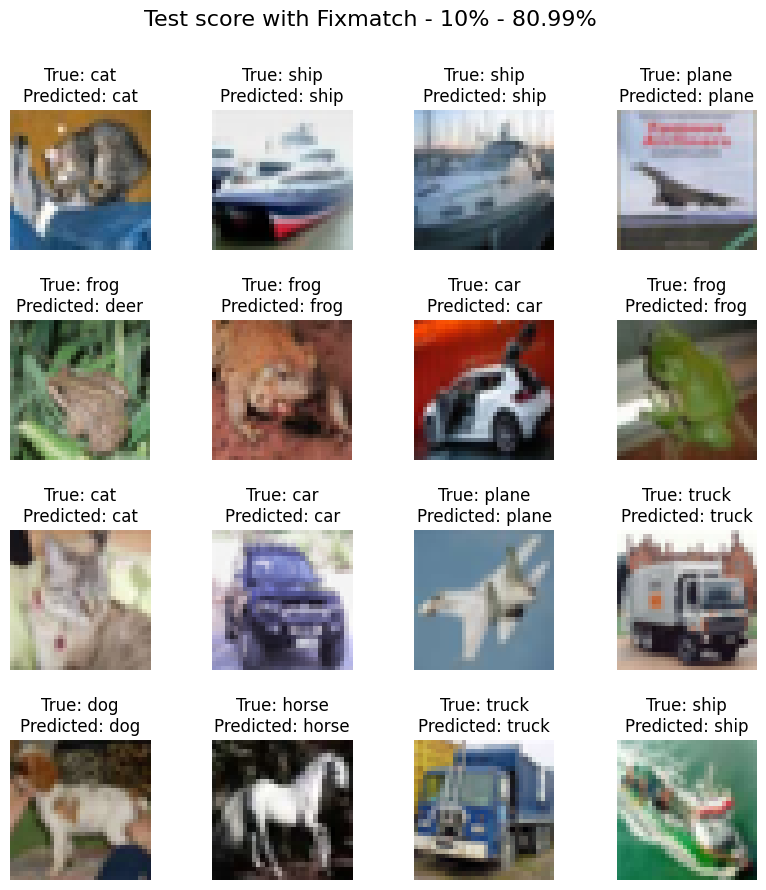

In [40]:
# Evaluation on the test set
test_accuracy = 100.0 * test_correct / test_total
print(f'Test Accuracy: {test_accuracy}%')

test_image, test_labels = testloader.__iter__().__next__()
test_image = test_image.to(device)
test_image_norm = normalize(mean, std)(test_image)
outputs_test = model_10(test_image_norm)
label_pred_test = outputs_test.argmax(dim=1)

fig1 = plot_images(test_image, test_labels, label_pred_test, classes, figure_name=f"Test score with Fixmatch - {int(SUBSET_PROP*100)}% - {test_accuracy:.2f}%")
fig1.savefig(f"./results/figures/test_score_10.png")

### III.2 Fixmatch on 5% train data

In [26]:
# fix the seed
seedEverything()

# 10% labeled data and 100% unlabeled (see note 2 in paper)
SUBSET_PROP = 0.05
trainset_sup, _ = torch.utils.data.random_split(trainset, [SUBSET_PROP, 1-SUBSET_PROP])

trainset_unsup, _ = torch.utils.data.random_split(trainset, [1, 0])

labeled_dataloader = DataLoader(
    trainset_sup,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=0
)

unlabeled_dataloader = DataLoader(
    trainset_unsup,
    batch_size=MU*BATCH_SIZE,
    shuffle=True,
    num_workers=0
)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataset.py:348: UserWarning: Length of split at index 1 is 0. This might result in an empty dataset.
  warnings.warn(f"Length of split at index {i} is 0. "


In [27]:
EPOCHS = 300

model = ConvNN().to(device)

# criterion and optimizer
labeled_criterion = nn.CrossEntropyLoss(reduction='none')
unlabeled_criterion = nn.CrossEntropyLoss(reduction='none')

optimizer = torch.optim.SGD(model.parameters(), lr=LR, momentum=BETA, weight_decay=WEIGHT_DECAY, nesterov=True)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)

In [28]:
fixmatch_train(
    model=model,
    labeled_dataloader=labeled_dataloader,
    unlabeled_dataloader=unlabeled_dataloader,
    testloader=testloader,
    labeled_criterion=labeled_criterion,
    unlabeled_criterion=unlabeled_criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    epochs=EPOCHS,
    mean=mean,
    std=std,
    lambda_u=LAMBDA_U,
    tau=TAU,
    mu=MU,
    batch_size=BATCH_SIZE,
    name='05'
)

Start training


Epoch     0:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 21.26%


Epoch     1:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 22.45%


Epoch     2:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 32.46%


Epoch     3:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 20.19%


Epoch     4:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 32.63%


Epoch     5:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 35.74%


Epoch     6:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 36.46%


Epoch     7:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 40.29%


Epoch     8:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 37.15%


Epoch     9:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 42.02%


Epoch    10:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 40.05%


Epoch    11:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 45.18%


Epoch    12:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 47.5%


Epoch    13:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 48.02%


Epoch    14:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 48.98%


Epoch    15:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 49.9%


Epoch    16:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 51.95%


Epoch    17:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 51.86%


Epoch    18:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 51.22%


Epoch    19:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 54.16%


Epoch    20:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 54.27%


Epoch    21:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 49.47%


Epoch    22:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 56.35%


Epoch    23:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 51.92%


Epoch    24:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 54.94%


Epoch    25:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 51.84%


Epoch    26:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 53.82%


Epoch    27:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 51.86%


Epoch    28:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 56.04%


Epoch    29:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 57.43%


Epoch    30:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 57.37%


Epoch    31:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 56.25%


Epoch    32:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 57.43%


Epoch    33:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 58.82%


Epoch    34:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 60.43%


Epoch    35:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 57.6%


Epoch    36:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 59.48%


Epoch    37:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 59.45%


Epoch    38:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 57.11%


Epoch    39:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 61.34%


Epoch    40:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 59.95%


Epoch    41:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 61.0%


Epoch    42:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 61.44%


Epoch    43:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 61.15%


Epoch    44:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 63.14%


Epoch    45:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 59.05%


Epoch    46:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 61.49%


Epoch    47:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 62.11%


Epoch    48:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 56.89%


Epoch    49:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 61.85%


Epoch    50:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 63.52%


Epoch    51:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 60.82%


Epoch    52:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 61.2%


Epoch    53:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 62.91%


Epoch    54:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 62.64%


Epoch    55:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 65.44%


Epoch    56:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 64.33%


Epoch    57:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 61.4%


Epoch    58:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 60.49%


Epoch    59:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 63.74%


Epoch    60:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 63.5%


Epoch    61:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 64.32%


Epoch    62:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 63.83%


Epoch    63:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 63.37%


Epoch    64:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 63.48%


Epoch    65:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 64.77%


Epoch    66:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 64.88%


Epoch    67:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 61.96%


Epoch    68:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 60.87%


Epoch    69:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 63.76%


Epoch    70:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 64.81%


Epoch    71:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 65.2%


Epoch    72:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 64.15%


Epoch    73:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 65.78%


Epoch    74:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 65.55%


Epoch    75:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 64.4%


Epoch    76:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 67.38%


Epoch    77:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 66.52%


Epoch    78:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 65.51%


Epoch    79:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 65.42%


Epoch    80:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 65.02%


Epoch    81:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 65.79%


Epoch    82:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 66.41%


Epoch    83:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 63.75%


Epoch    84:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 65.99%


Epoch    85:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 67.43%


Epoch    86:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 66.79%


Epoch    87:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 68.0%


Epoch    88:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 67.72%


Epoch    89:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 65.67%


Epoch    90:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 66.99%


Epoch    91:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 67.45%


Epoch    92:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 67.3%


Epoch    93:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 68.22%


Epoch    94:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 67.71%


Epoch    95:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 68.75%


Epoch    96:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 68.05%


Epoch    97:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 66.64%


Epoch    98:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 67.35%


Epoch    99:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 67.04%


Epoch   100:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 68.7%


Epoch   101:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 69.1%


Epoch   102:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 68.15%


Epoch   103:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 68.13%


Epoch   104:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 67.66%


Epoch   105:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 68.15%


Epoch   106:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 68.82%


Epoch   107:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 66.94%


Epoch   108:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 69.08%


Epoch   109:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 69.06%


Epoch   110:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 69.17%


Epoch   111:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 69.34%


Epoch   112:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 68.47%


Epoch   113:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 70.16%


Epoch   114:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 68.48%


Epoch   115:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 70.03%


Epoch   116:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 68.41%


Epoch   117:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 69.06%


Epoch   118:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 69.38%


Epoch   119:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 70.57%


Epoch   120:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 70.01%


Epoch   121:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 69.98%


Epoch   122:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 69.94%


Epoch   123:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 70.2%


Epoch   124:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 67.49%


Epoch   125:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 69.58%


Epoch   126:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 70.49%


Epoch   127:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 69.63%


Epoch   128:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 70.81%


Epoch   129:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 70.24%


Epoch   130:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 69.22%


Epoch   131:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 71.13%


Epoch   132:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 70.93%


Epoch   133:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 70.69%


Epoch   134:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 71.25%


Epoch   135:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 69.87%


Epoch   136:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 70.83%


Epoch   137:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 71.03%


Epoch   138:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 71.55%


Epoch   139:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 71.83%


Epoch   140:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 71.14%


Epoch   141:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 71.55%


Epoch   142:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 71.51%


Epoch   143:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 71.17%


Epoch   144:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 71.59%


Epoch   145:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 71.64%


Epoch   146:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 71.85%


Epoch   147:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 72.09%


Epoch   148:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 71.78%


Epoch   149:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 72.07%


Epoch   150:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 71.61%


Epoch   151:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 72.49%


Epoch   152:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 72.08%


Epoch   153:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 72.23%


Epoch   154:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 71.34%


Epoch   155:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 70.69%


Epoch   156:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 72.01%


Epoch   157:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 72.76%


Epoch   158:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 72.68%


Epoch   159:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 72.18%


Epoch   160:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 71.94%


Epoch   161:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 72.35%


Epoch   162:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 72.93%


Epoch   163:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 72.53%


Epoch   164:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 72.43%


Epoch   165:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 72.71%


Epoch   166:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 72.75%


Epoch   167:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 73.31%


Epoch   168:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 73.02%


Epoch   169:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 72.9%


Epoch   170:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 73.2%


Epoch   171:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 72.8%


Epoch   172:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 73.27%


Epoch   173:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 72.47%


Epoch   174:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 73.07%


Epoch   175:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 73.66%


Epoch   176:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 72.97%


Epoch   177:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 73.28%


Epoch   178:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 73.21%


Epoch   179:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 73.87%


Epoch   180:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 73.16%


Epoch   181:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 73.71%


Epoch   182:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 73.8%


Epoch   183:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 73.64%


Epoch   184:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 73.1%


Epoch   185:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 73.42%


Epoch   186:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 73.5%


Epoch   187:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 73.61%


Epoch   188:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 73.79%


Epoch   189:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 74.12%


Epoch   190:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 74.2%


Epoch   191:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 73.98%


Epoch   192:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 73.15%


Epoch   193:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 74.29%


Epoch   194:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 73.67%


Epoch   195:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 73.66%


Epoch   196:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 73.78%


Epoch   197:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 74.09%


Epoch   198:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 74.24%


Epoch   199:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 74.09%


Epoch   200:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 73.48%


Epoch   201:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 74.22%


Epoch   202:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 74.38%


Epoch   203:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 74.16%


Epoch   204:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 74.55%


Epoch   205:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 74.19%


Epoch   206:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 74.29%


Epoch   207:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 74.3%


Epoch   208:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 74.64%


Epoch   209:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 74.7%


Epoch   210:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 74.28%


Epoch   211:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 74.77%


Epoch   212:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 74.32%


Epoch   213:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 74.34%


Epoch   214:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 74.9%


Epoch   215:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 74.54%


Epoch   216:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 74.09%


Epoch   217:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 74.49%


Epoch   218:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 74.86%


Epoch   219:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 74.6%


Epoch   220:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 75.11%


Epoch   221:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 75.08%


Epoch   222:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 74.88%


Epoch   223:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 74.74%


Epoch   224:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 74.67%


Epoch   225:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 74.99%


Epoch   226:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 74.52%


Epoch   227:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 74.86%


Epoch   228:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 74.6%


Epoch   229:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 75.16%


Epoch   230:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 75.22%


Epoch   231:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 75.29%


Epoch   232:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 74.87%


Epoch   233:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 74.72%


Epoch   234:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 75.14%


Epoch   235:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 75.19%


Epoch   236:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 75.1%


Epoch   237:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 75.01%


Epoch   238:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 75.16%


Epoch   239:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 74.83%


Epoch   240:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 74.74%


Epoch   241:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 75.12%


Epoch   242:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 75.56%


Epoch   243:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 75.29%


Epoch   244:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 75.24%


Epoch   245:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 75.42%


Epoch   246:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 75.32%


Epoch   247:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 75.5%


Epoch   248:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 75.68%


Epoch   249:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 75.34%


Epoch   250:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 75.11%


Epoch   251:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 75.4%


Epoch   252:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 75.62%


Epoch   253:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 75.43%


Epoch   254:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 75.44%


Epoch   255:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 75.26%


Epoch   256:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 75.53%


Epoch   257:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 75.82%


Epoch   258:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 75.82%


Epoch   259:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 75.73%


Epoch   260:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 75.63%


Epoch   261:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 75.32%


Epoch   262:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 75.21%


Epoch   263:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 75.45%


Epoch   264:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 75.58%


Epoch   265:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 75.37%


Epoch   266:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 75.65%


Epoch   267:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 75.37%


Epoch   268:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 75.52%


Epoch   269:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 75.66%


Epoch   270:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 75.62%


Epoch   271:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 75.76%


Epoch   272:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 75.65%


Epoch   273:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 75.49%


Epoch   274:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 75.6%


Epoch   275:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 75.78%


Epoch   276:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 75.68%


Epoch   277:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 75.75%


Epoch   278:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 75.69%


Epoch   279:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 75.7%


Epoch   280:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 75.92%


Epoch   281:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 75.93%


Epoch   282:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 75.74%


Epoch   283:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 75.75%


Epoch   284:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 75.89%


Epoch   285:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 75.87%


Epoch   286:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 75.81%


Epoch   287:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 75.77%


Epoch   288:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 75.56%


Epoch   289:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 75.64%


Epoch   290:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 75.7%


Epoch   291:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 75.73%


Epoch   292:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 75.75%


Epoch   293:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 75.74%


Epoch   294:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 75.69%


Epoch   295:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 75.71%


Epoch   296:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 75.74%


Epoch   297:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 75.74%


Epoch   298:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 75.73%


Epoch   299:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 75.73%
Finished Training


In [29]:
# open results
model_05 = ConvNN().to(device)
model_05.load_state_dict(torch.load('./results/models/model_05.pth'))
train_losses_05 = torch.load('./results/metrics/train_losses_05.pth')
train_accuracies_05 = torch.load('./results/metrics/train_accuracies_05.pth')
test_losses_05 = torch.load('./results/metrics/test_losses_05.pth')
test_accuracies_05 = torch.load('./results/metrics/test_accuracies_05.pth')

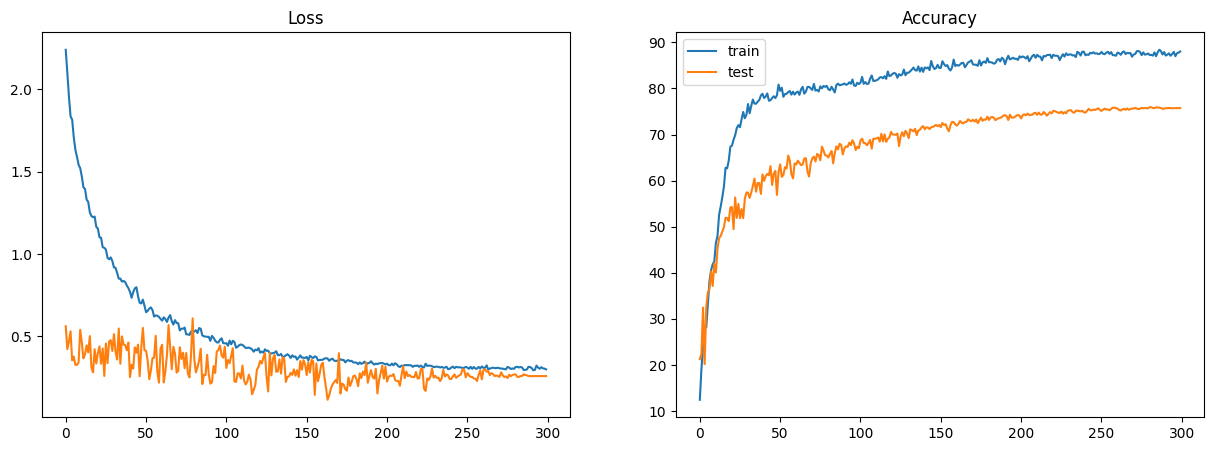

In [30]:
# plot losses and accuracies
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.plot(train_losses_05, label="train")
ax1.plot(test_losses_05, label="test")
ax1.set_title("Loss")

ax2.plot(train_accuracies_05, label="train")
ax2.plot(test_accuracies_05, label="test")
ax2.set_title("Accuracy")

plt.legend()
plt.show()

# save plot
fig.savefig(f"./results/figures/losses_accuracies_05.png")

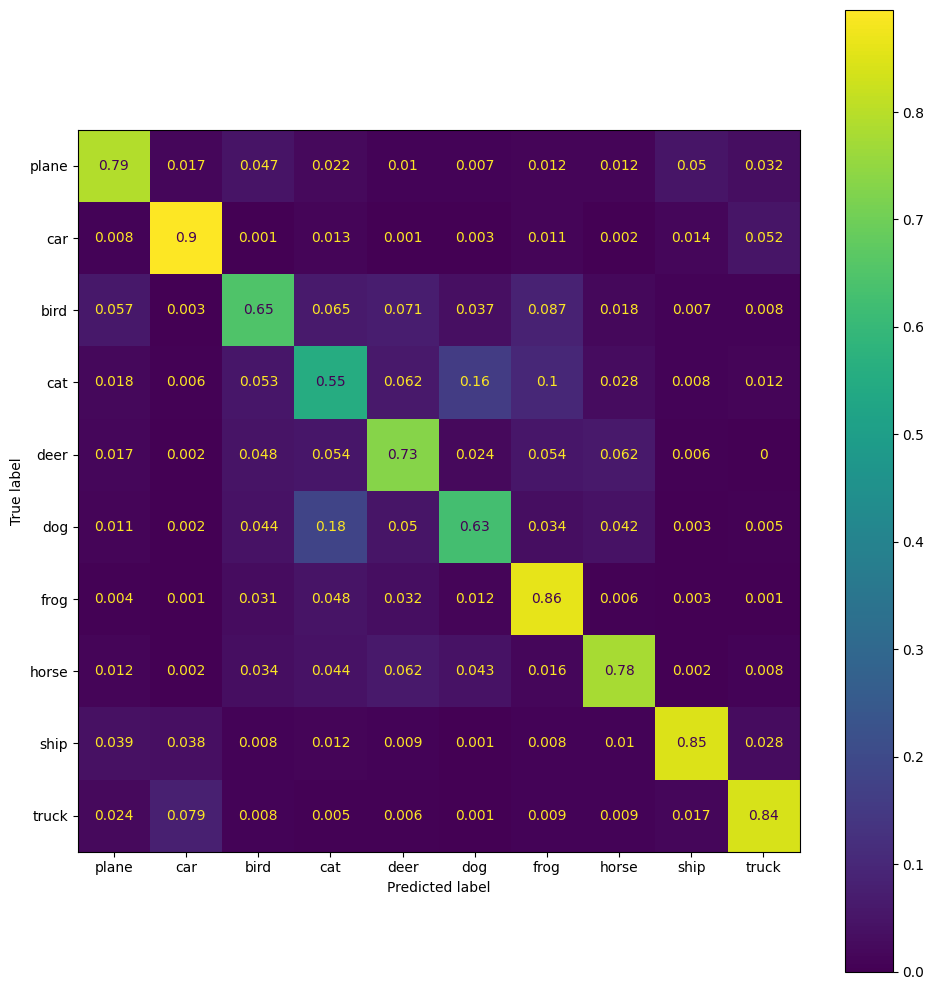

In [31]:
# plot confusion matrix
model.eval()  # Set the model to evaluation mode
test_correct = 0
test_total = 0
y_true = []
y_pred = []

with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        # normalize
        images = normalize(mean, std)(images)
        
        outputs = model_05(images)
        _, predicted = outputs.max(1)
        test_total += labels.size(0)
        test_correct += predicted.eq(labels).sum().item()

        y_true.append(labels.cpu().numpy())
        y_pred.append(predicted.cpu().numpy())
    
    y_true = np.concatenate(y_true)
    y_pred = np.concatenate(y_pred)

    fig, ax = plt.subplots(figsize=(10, 10))
    cm = confusion_matrix(y_true, y_pred, normalize='true')
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
    disp.plot(ax=ax)
    plt.tight_layout()
    plt.show()

    # save plot
    fig.savefig(f"./results/figures/confusion_matrix_05.png")

Test Accuracy: 75.73%


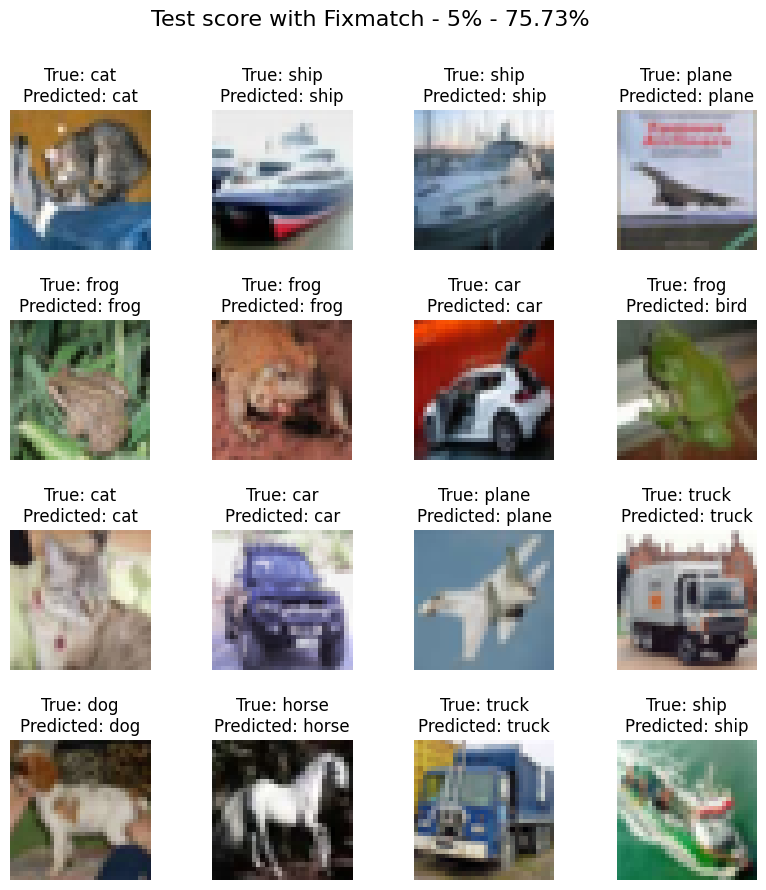

In [32]:
# Evaluation on the test set
test_accuracy = 100.0 * test_correct / test_total
print(f'Test Accuracy: {test_accuracy}%')

test_image, test_labels = testloader.__iter__().__next__()
test_image = test_image.to(device)
test_image_norm = normalize(mean, std)(test_image)
outputs_test = model_05(test_image_norm)
label_pred_test = outputs_test.argmax(dim=1)

fig1 = plot_images(test_image, test_labels, label_pred_test, classes, figure_name=f"Test score with Fixmatch - {int(SUBSET_PROP*100)}% - {test_accuracy:.2f}%")
fig1.savefig(f"./results/figures/test_score_05.png")

### III.3 Fixmatch on 1% train data

In [9]:
# fix the seed
seedEverything()

# 10% labeled data and 100% unlabeled (see note 2 in paper)
SUBSET_PROP = 0.01
trainset_sup, _ = torch.utils.data.random_split(trainset, [SUBSET_PROP, 1-SUBSET_PROP])

trainset_unsup, _ = torch.utils.data.random_split(trainset, [1, 0])

labeled_dataloader = DataLoader(
    trainset_sup,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=0
)

unlabeled_dataloader = DataLoader(
    trainset_unsup,
    batch_size=MU*BATCH_SIZE,
    shuffle=True,
    num_workers=0
)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataset.py:348: UserWarning: Length of split at index 1 is 0. This might result in an empty dataset.
  warnings.warn(f"Length of split at index {i} is 0. "


In [10]:
EPOCHS = 300

model = ConvNN().to(device)

# criterion and optimizer
labeled_criterion = nn.CrossEntropyLoss(reduction='none')
unlabeled_criterion = nn.CrossEntropyLoss(reduction='none')

optimizer = torch.optim.SGD(model.parameters(), lr=LR, momentum=BETA, weight_decay=WEIGHT_DECAY, nesterov=True)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)

In [11]:
fixmatch_train(
    model=model,
    labeled_dataloader=labeled_dataloader,
    unlabeled_dataloader=unlabeled_dataloader,
    testloader=testloader,
    labeled_criterion=labeled_criterion,
    unlabeled_criterion=unlabeled_criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    epochs=EPOCHS,
    mean=mean,
    std=std,
    lambda_u=LAMBDA_U,
    tau=TAU,
    mu=MU,
    batch_size=BATCH_SIZE,
    name='01'
)

Start training


Epoch     0:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 10.0%


Epoch     1:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 10.0%


Epoch     2:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 10.0%


Epoch     3:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 12.75%


Epoch     4:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 20.0%


Epoch     5:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 21.44%


Epoch     6:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 21.53%


Epoch     7:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 24.57%


Epoch     8:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 25.29%


Epoch     9:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 25.82%


Epoch    10:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 26.17%


Epoch    11:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 27.55%


Epoch    12:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 29.09%


Epoch    13:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 28.79%


Epoch    14:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 32.04%


Epoch    15:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 31.7%


Epoch    16:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 32.26%


Epoch    17:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 34.3%


Epoch    18:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 28.68%


Epoch    19:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 31.47%


Epoch    20:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 35.59%


Epoch    21:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 32.92%


Epoch    22:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 32.73%


Epoch    23:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 33.34%


Epoch    24:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 34.05%


Epoch    25:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 39.05%


Epoch    26:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 38.87%


Epoch    27:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 33.43%


Epoch    28:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 38.34%


Epoch    29:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 37.36%


Epoch    30:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 34.77%


Epoch    31:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 35.57%


Epoch    32:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 34.23%


Epoch    33:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 37.92%


Epoch    34:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 38.02%


Epoch    35:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 37.49%


Epoch    36:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 37.78%


Epoch    37:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 40.41%


Epoch    38:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 38.19%


Epoch    39:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 39.22%


Epoch    40:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 39.27%


Epoch    41:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 37.59%


Epoch    42:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 38.7%


Epoch    43:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 40.16%


Epoch    44:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 38.21%


Epoch    45:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 38.94%


Epoch    46:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 39.87%


Epoch    47:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 35.84%


Epoch    48:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 38.49%


Epoch    49:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 38.87%


Epoch    50:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 41.04%


Epoch    51:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 40.49%


Epoch    52:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 40.4%


Epoch    53:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 40.28%


Epoch    54:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 41.13%


Epoch    55:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 40.05%


Epoch    56:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 39.76%


Epoch    57:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 41.35%


Epoch    58:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 40.15%


Epoch    59:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 40.62%


Epoch    60:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 41.69%


Epoch    61:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 39.85%


Epoch    62:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 42.3%


Epoch    63:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 40.54%


Epoch    64:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 41.48%


Epoch    65:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 41.95%


Epoch    66:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 41.07%


Epoch    67:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 41.67%


Epoch    68:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 40.1%


Epoch    69:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 40.04%


Epoch    70:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 40.14%


Epoch    71:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 41.68%


Epoch    72:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 40.26%


Epoch    73:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 41.19%


Epoch    74:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 42.2%


Epoch    75:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 42.97%


Epoch    76:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 41.82%


Epoch    77:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 43.21%


Epoch    78:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 43.83%


Epoch    79:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 43.35%


Epoch    80:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 43.18%


Epoch    81:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 44.84%


Epoch    82:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 42.58%


Epoch    83:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 41.99%


Epoch    84:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 42.12%


Epoch    85:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 43.32%


Epoch    86:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 42.39%


Epoch    87:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 42.63%


Epoch    88:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 42.68%


Epoch    89:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 41.49%


Epoch    90:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 43.74%


Epoch    91:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 43.49%


Epoch    92:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 43.91%


Epoch    93:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 43.83%


Epoch    94:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 44.6%


Epoch    95:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 44.05%


Epoch    96:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 44.66%


Epoch    97:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 44.5%


Epoch    98:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 44.41%


Epoch    99:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 43.44%


Epoch   100:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 43.05%


Epoch   101:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 44.64%


Epoch   102:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 45.36%


Epoch   103:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 44.09%


Epoch   104:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 46.07%


Epoch   105:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 45.53%


Epoch   106:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 45.42%


Epoch   107:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 44.95%


Epoch   108:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 45.06%


Epoch   109:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 45.44%


Epoch   110:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 45.91%


Epoch   111:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 45.45%


Epoch   112:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 45.44%


Epoch   113:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 44.31%


Epoch   114:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 44.12%


Epoch   115:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 44.43%


Epoch   116:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 45.12%


Epoch   117:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 45.53%


Epoch   118:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 46.11%


Epoch   119:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 46.43%


Epoch   120:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 44.6%


Epoch   121:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 45.59%


Epoch   122:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 44.82%


Epoch   123:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 44.76%


Epoch   124:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 45.24%


Epoch   125:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 45.05%


Epoch   126:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 45.55%


Epoch   127:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 46.13%


Epoch   128:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 45.42%


Epoch   129:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 46.47%


Epoch   130:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 45.08%


Epoch   131:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 45.25%


Epoch   132:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 45.59%


Epoch   133:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 46.86%


Epoch   134:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 45.51%


Epoch   135:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 45.48%


Epoch   136:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 46.72%


Epoch   137:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 45.6%


Epoch   138:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 44.98%


Epoch   139:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 46.44%


Epoch   140:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 45.86%


Epoch   141:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 45.78%


Epoch   142:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 45.93%


Epoch   143:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 46.07%


Epoch   144:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 46.44%


Epoch   145:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 46.82%


Epoch   146:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 46.96%


Epoch   147:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 46.43%


Epoch   148:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 46.46%


Epoch   149:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 45.46%


Epoch   150:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 46.66%


Epoch   151:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 45.9%


Epoch   152:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 45.94%


Epoch   153:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 46.27%


Epoch   154:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 46.61%


Epoch   155:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 46.86%


Epoch   156:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 46.26%


Epoch   157:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 46.35%


Epoch   158:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 46.46%


Epoch   159:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 47.05%


Epoch   160:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 47.98%


Epoch   161:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 47.34%


Epoch   162:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 48.05%


Epoch   163:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 47.35%


Epoch   164:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 47.22%


Epoch   165:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 47.62%


Epoch   166:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 47.39%


Epoch   167:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 47.24%


Epoch   168:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 46.93%


Epoch   169:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 46.56%


Epoch   170:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 47.0%


Epoch   171:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 47.43%


Epoch   172:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 47.17%


Epoch   173:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 46.89%


Epoch   174:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 47.45%


Epoch   175:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 49.1%


Epoch   176:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 48.47%


Epoch   177:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 47.52%


Epoch   178:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 47.34%


Epoch   179:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 47.55%


Epoch   180:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 46.48%


Epoch   181:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 46.74%


Epoch   182:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 47.59%


Epoch   183:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 48.51%


Epoch   184:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 47.88%


Epoch   185:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 47.18%


Epoch   186:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 47.26%


Epoch   187:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 47.63%


Epoch   188:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 47.9%


Epoch   189:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 47.84%


Epoch   190:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 48.07%


Epoch   191:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 47.82%


Epoch   192:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 48.07%


Epoch   193:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 47.73%


Epoch   194:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 47.76%


Epoch   195:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 47.64%


Epoch   196:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 48.62%


Epoch   197:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 48.92%


Epoch   198:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 48.5%


Epoch   199:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 48.46%


Epoch   200:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 48.97%


Epoch   201:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 48.28%


Epoch   202:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 48.4%


Epoch   203:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 49.03%


Epoch   204:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 48.71%


Epoch   205:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 48.56%


Epoch   206:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 48.89%


Epoch   207:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 48.45%


Epoch   208:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 48.85%


Epoch   209:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 48.68%


Epoch   210:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 48.76%


Epoch   211:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 48.68%


Epoch   212:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 48.84%


Epoch   213:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 48.96%


Epoch   214:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 48.84%


Epoch   215:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 48.46%


Epoch   216:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 48.68%


Epoch   217:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 48.87%


Epoch   218:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 48.73%


Epoch   219:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 48.45%


Epoch   220:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 49.02%


Epoch   221:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 49.03%


Epoch   222:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 48.66%


Epoch   223:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 49.23%


Epoch   224:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 49.69%


Epoch   225:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 49.26%


Epoch   226:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 48.74%


Epoch   227:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 48.89%


Epoch   228:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 49.32%


Epoch   229:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 48.78%


Epoch   230:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 48.85%


Epoch   231:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 49.12%


Epoch   232:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 48.95%


Epoch   233:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 48.82%


Epoch   234:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 48.79%


Epoch   235:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 48.79%


Epoch   236:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 48.91%


Epoch   237:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 48.98%


Epoch   238:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 49.42%


Epoch   239:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 49.4%


Epoch   240:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 49.2%


Epoch   241:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 48.78%


Epoch   242:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 49.07%


Epoch   243:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 49.33%


Epoch   244:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 48.98%


Epoch   245:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 49.3%


Epoch   246:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 49.3%


Epoch   247:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 49.32%


Epoch   248:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 49.06%


Epoch   249:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 49.11%


Epoch   250:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 48.93%


Epoch   251:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 49.09%


Epoch   252:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 49.16%


Epoch   253:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 49.26%


Epoch   254:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 49.17%


Epoch   255:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 49.17%


Epoch   256:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 49.18%


Epoch   257:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 49.16%


Epoch   258:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 49.2%


Epoch   259:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 49.04%


Epoch   260:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 48.97%


Epoch   261:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 48.63%


Epoch   262:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 48.81%


Epoch   263:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 49.23%


Epoch   264:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 49.35%


Epoch   265:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 49.38%


Epoch   266:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 49.43%


Epoch   267:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 49.57%


Epoch   268:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 49.43%


Epoch   269:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 49.39%


Epoch   270:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 49.54%


Epoch   271:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 49.52%


Epoch   272:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 49.48%


Epoch   273:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 49.4%


Epoch   274:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 49.32%


Epoch   275:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 49.33%


Epoch   276:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 49.31%


Epoch   277:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 49.43%


Epoch   278:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 49.49%


Epoch   279:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 49.47%


Epoch   280:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 49.47%


Epoch   281:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 49.59%


Epoch   282:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 49.58%


Epoch   283:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 49.6%


Epoch   284:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 49.59%


Epoch   285:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 49.59%


Epoch   286:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 49.6%


Epoch   287:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 49.6%


Epoch   288:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 49.59%


Epoch   289:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 49.59%


Epoch   290:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 49.6%


Epoch   291:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 49.6%


Epoch   292:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 49.59%


Epoch   293:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 49.57%


Epoch   294:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 49.58%


Epoch   295:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 49.57%


Epoch   296:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 49.57%


Epoch   297:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 49.57%


Epoch   298:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 49.57%


Epoch   299:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 49.57%
Finished Training


In [16]:
# open results
model_01 = ConvNN().to(device)
model_01.load_state_dict(torch.load('./results/models/model_01.pth'))
train_losses_01 = torch.load('./results/metrics/train_losses_01.pth')
train_accuracies_01 = torch.load('./results/metrics/train_accuracies_01.pth')
test_losses_01 = torch.load('./results/metrics/test_losses_01.pth')
test_accuracies_01 = torch.load('./results/metrics/test_accuracies_01.pth')

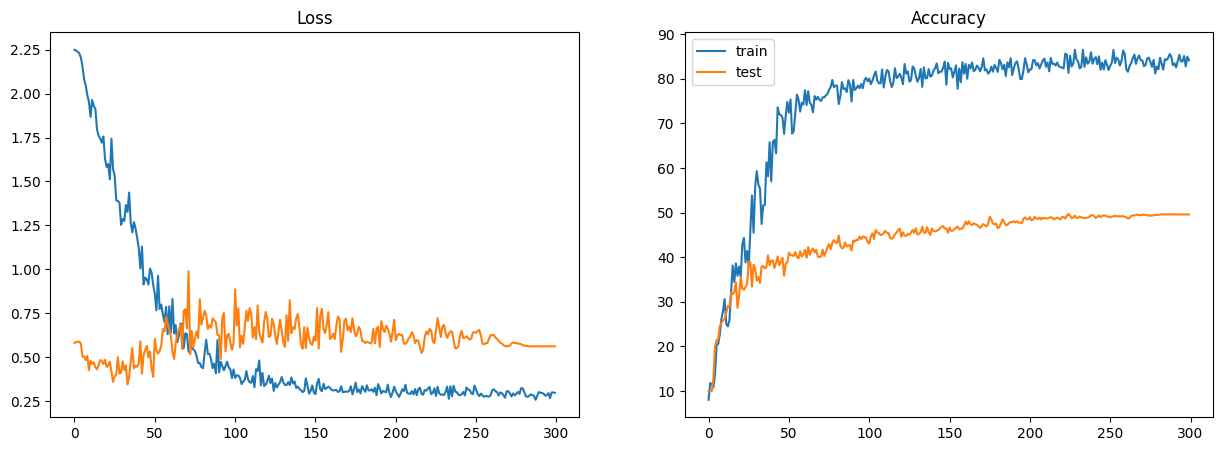

In [17]:
# plot losses and accuracies
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.plot(train_losses_01, label="train")
ax1.plot(test_losses_01, label="test")
ax1.set_title("Loss")

ax2.plot(train_accuracies_01, label="train")
ax2.plot(test_accuracies_01, label="test")
ax2.set_title("Accuracy")

plt.legend()
plt.show()

# save plot
fig.savefig(f"./results/figures/losses_accuracies_01.png")

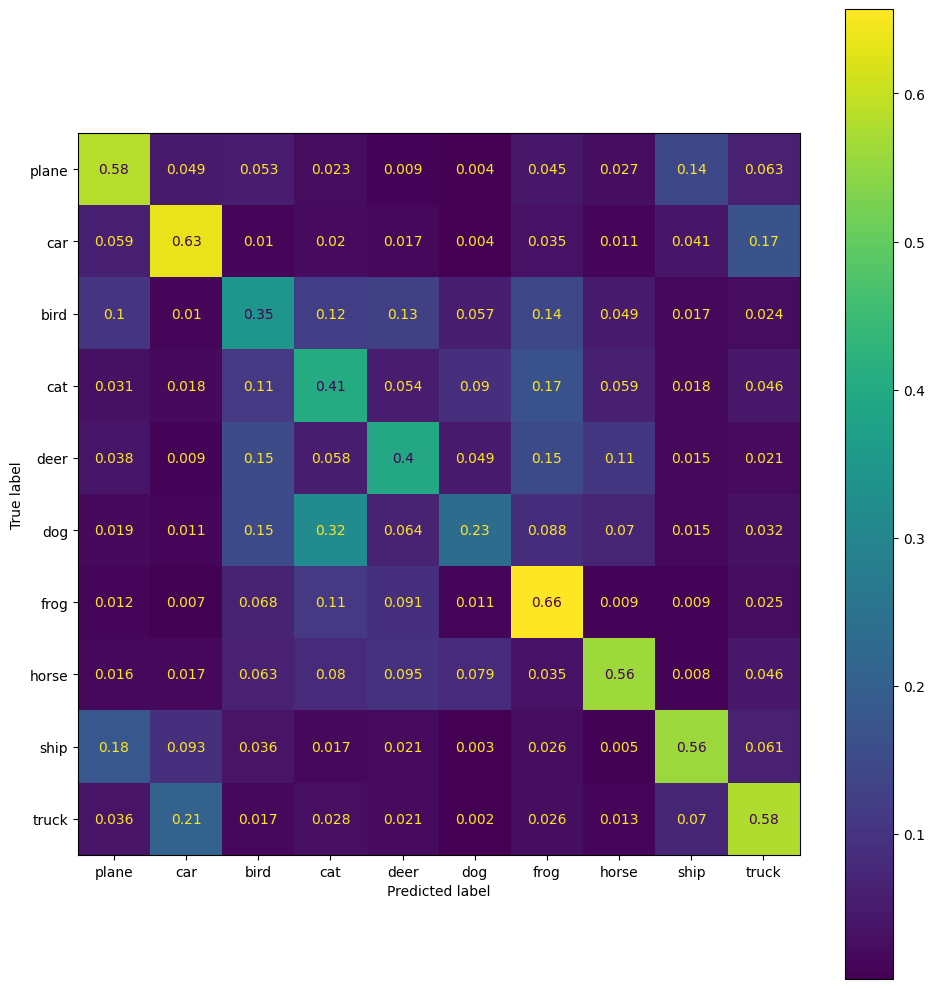

In [18]:
# plot confusion matrix
model.eval()  # Set the model to evaluation mode
test_correct = 0
test_total = 0
y_true = []
y_pred = []

with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        # normalize
        images = normalize(mean, std)(images)
        
        outputs = model_01(images)
        _, predicted = outputs.max(1)
        test_total += labels.size(0)
        test_correct += predicted.eq(labels).sum().item()

        y_true.append(labels.cpu().numpy())
        y_pred.append(predicted.cpu().numpy())
    
    y_true = np.concatenate(y_true)
    y_pred = np.concatenate(y_pred)

    fig, ax = plt.subplots(figsize=(10, 10))
    cm = confusion_matrix(y_true, y_pred, normalize='true')
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
    disp.plot(ax=ax)
    plt.tight_layout()
    plt.show()

    # save plot
    fig.savefig(f"./results/figures/confusion_matrix_01.png")

Test Accuracy: 49.57%


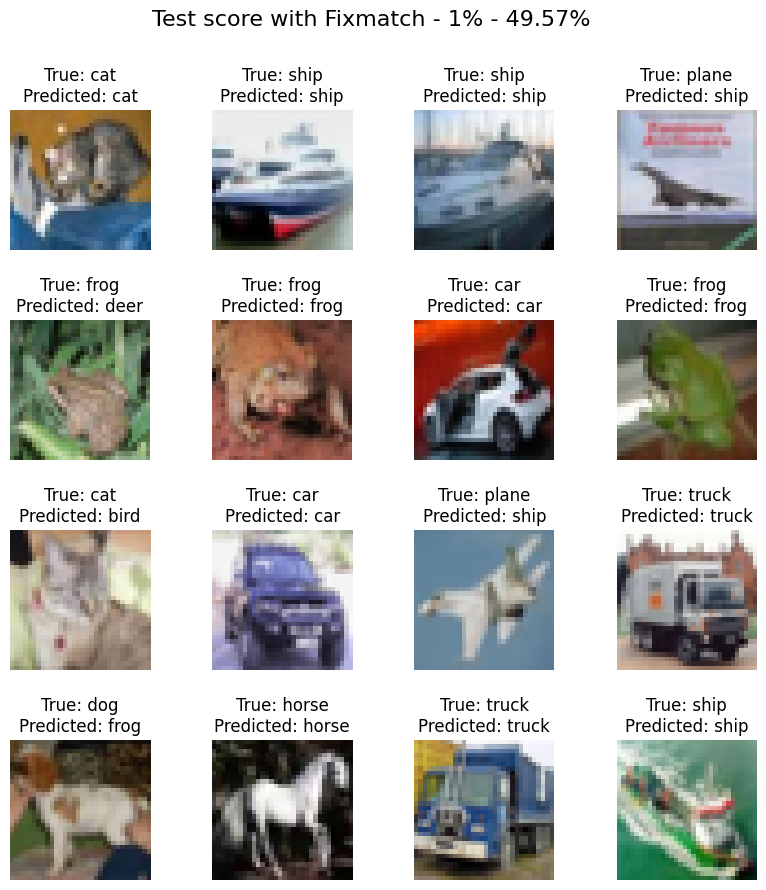

In [25]:
# Evaluation on the test set
test_accuracy = 100.0 * test_correct / test_total
print(f'Test Accuracy: {test_accuracy}%')

test_image, test_labels = testloader.__iter__().__next__()
test_image = test_image.to(device)
test_image_norm = normalize(mean, std)(test_image)
outputs_test = model_01(test_image_norm)
label_pred_test = outputs_test.argmax(dim=1)

fig1 = plot_images(test_image, test_labels, label_pred_test, classes, figure_name=f"Test score with Fixmatch - {int(SUBSET_PROP*100)}% - {test_accuracy:.2f}%")
fig1.savefig(f"./results/figures/test_score_01.png")